# Deploy machine learned models with ONNX

**Xavier Dupré** - Senior Data Scientist at Microsoft - Computer Science Teacher at [ENSAE](http://www.ensae.fr/)

Most of machine learning libraries are optimized to train models and not necessarily to use them for fast predictions in online web services. [ONNX](https://onnx.ai/) is one solution started last year by Microsoft and Facebook. This presentation describes the concept and shows some examples with [scikit-learn](http://scikit-learn.org/stable/) and [ML.net](https://github.com/dotnet/machinelearning).


* [github/xadupre](https://github.com/xadupre)
* [github/sdpython](https://github.com/sdpython)

La plupart des libraires de machine learning sont optimisées pour entraîner des modèles et pas nécessairement les utiliser dans des sites internet online où l'exigence de rapidité est importante. [ONNX](https://onnx.ai/), une initiative open source proposée l'année dernière par Microsoft et Facebook est une réponse à ce problème. Ce talk illustrera ce concept avec un démo mêlant deep learning, [scikit-learn](http://scikit-learn.org/stable/) et [ML.net](https://github.com/dotnet/machinelearning), la librairie de machine learning open source écrite en C# et développée par Microsoft.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=2)

In [2]:
from pyquickhelper.helpgen import NbImage

## Open source tools in this talk

In [3]:
import keras, lightgbm, onnx, skl2onnx, onnxruntime, sklearn, torch, xgboost
mods = [keras, lightgbm, onnx, skl2onnx, onnxruntime, sklearn, torch, xgboost]
for m in mods:
    print(m.__name__, m.__version__)

Using TensorFlow backend.


keras 2.3.1
lightgbm 2.3.1
onnx 1.7.105
skl2onnx 1.7.0
onnxruntime 1.3.993
sklearn 0.24.dev0
torch 1.5.0+cpu
xgboost 1.1.0


### ML.net

* Open source in 2018
* [ML.net](https://github.com/dotnet/machinelearning)
* Machine learning library written in C#
* Used in many places in Microsoft Services (Bing, ...)
* Working on it for three years

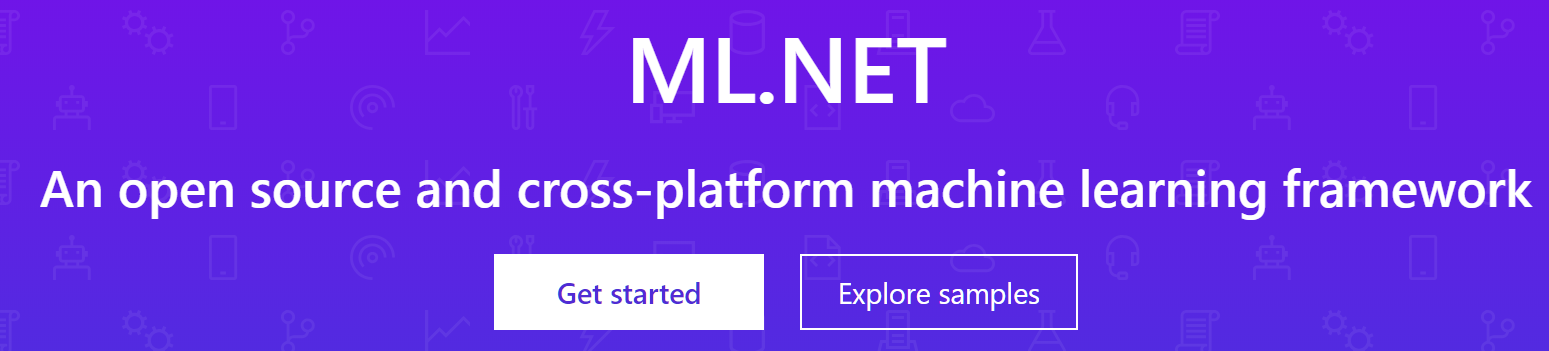

In [4]:
NbImage("mlnet.png", width=500)

### onnx

* Serialisation library specialized for machine learning based on [Google.Protobuf](https://developers.google.com/protocol-buffers/)
* Open source in 2017
* [onnx](https://github.com/onnx/onnx)

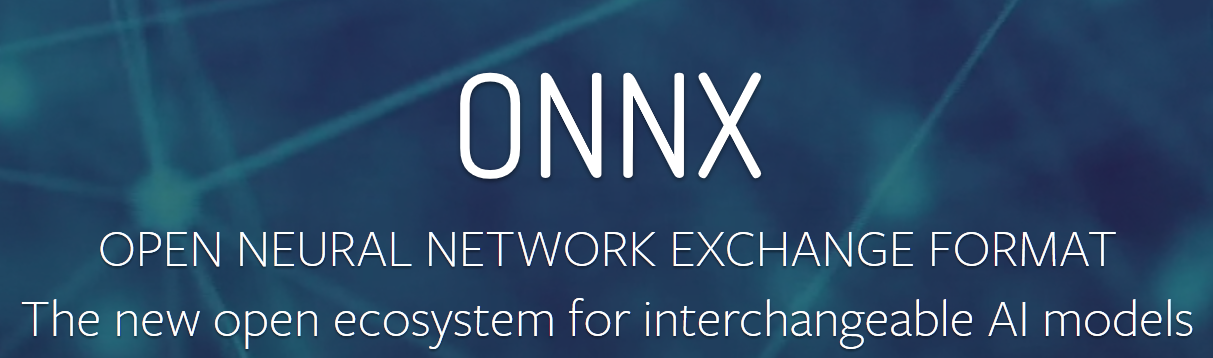

In [5]:
NbImage("onnx.png", width=500)

### sklearn-learn

* Open source in 2018
* Converters for *scikit-learn* models
* [sklearn-onnx](https://github.com/onnx/sklearn-onnx)

In [6]:
NbImage("sklearn-onnx.png")

### onnxruntime

* Open source in December 2018
* Available on [Pypi/onnxruntime](https://pypi.org/project/onnxruntime/)
* documentation is [here](https://docs.microsoft.com/en-us/python/api/overview/azure/onnx/intro?view=azure-onnx-py)
* source on [microsoft/onnxruntime](https://github.com/Microsoft/onnxruntime)
* Working on it for a couple of months

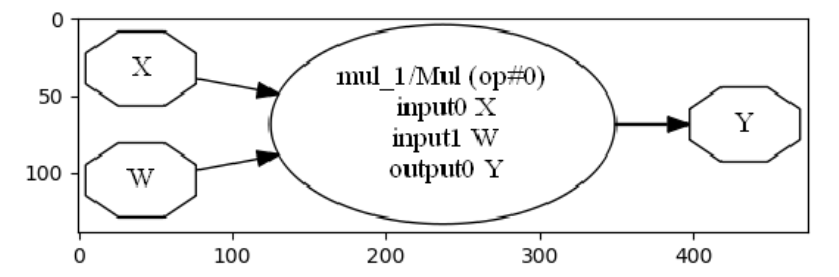

In [7]:
NbImage("onnxruntime.png", width=400)

### Others tools

* [scikit-learn](http://scikit-learn.org/)
* [xgboost](https://xgboost.readthedocs.io/en/latest/)
* [lightgbm](https://lightgbm.readthedocs.io/en/latest/)
* [keras](https://keras.io/)
* [pytorch](https://pytorch.org/)

## The problem about deployment

### Learn and predict

* Two different purposes not necessarily aligned for optimization
* **Learn** : computation optimized for large number of observations (*batch prediction*)
* **Predict** : computation optimized for one observation (*one-off prediction*)
* Machine learning libraries optimize the **learn** scenario.

### Illustration with a linear regression

We consider a datasets available in *scikit-learn*: [diabetes](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)

In [8]:
measures_lr = []

In [9]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]
diabetes_X_train[:1]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613]])

#### scikit-learn

In [10]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(diabetes_X_train, diabetes_y_train)

LinearRegression()

In [11]:
clr.predict(diabetes_X_test[:1])

array([197.61846908])

In [12]:
from jupytalk.benchmark import timeexec
measures_lr += [timeexec("sklearn", 
                         "clr.predict(diabetes_X_test[:1])",
                         context=globals())]

Average: 81.64 µs deviation 45.34 µs (with 50 runs) in [48.70 µs, 164.52 µs]


#### pure python

In [13]:
def python_prediction(X, coef, intercept):
    s = intercept
    for a, b in zip(X, coef):
        s += a * b
    return s

python_prediction(diabetes_X_test[0], clr.coef_, clr.intercept_)

197.6184690750328

In [14]:
measures_lr += [timeexec("python",
                         "python_prediction(diabetes_X_test[0], clr.coef_, clr.intercept_)", 
                         context=globals())]

Average: 12.53 µs deviation 9.88 µs (with 50 runs) in [5.92 µs, 28.09 µs]


### Summary

In [15]:
import pandas
df = pandas.DataFrame(data=measures_lr)
df = df.set_index("legend").sort_values("average")
df

,average,deviation,first,first3,last3,repeat,min5,max5,code,run
legend,,,,,,,,,,
python,0.000013,0.000010,0.000021,0.000015,0.000007,200,0.000006,0.000028,"python_prediction(diabetes_X_test[0], clr.coef...",50
sklearn,0.000082,0.000045,0.000165,0.000139,0.000070,200,0.000049,0.000165,clr.predict(diabetes_X_test[:1]),50


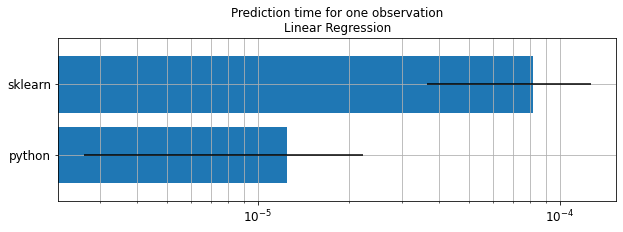

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nLinear Regression");

### Illustration with a random forest

In [17]:
measures_rf = []

#### scikit-learn

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
rf.fit(diabetes_X_train, diabetes_y_train)

RandomForestRegressor(n_estimators=10)

In [19]:
measures_rf += [timeexec("sklearn", "rf.predict(diabetes_X_test[:1])", 
                         context=globals())]

Average: 1.01 ms deviation 155.50 µs (with 50 runs) in [852.33 µs, 1.37 ms]


#### XGBoost

In [20]:
from xgboost import XGBRegressor
xg = XGBRegressor(n_estimators=10)
xg.fit(diabetes_X_train, diabetes_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
measures_rf += [timeexec("xgboost", "xg.predict(diabetes_X_test[:1])",
                         context=globals())]

Average: 1.48 ms deviation 322.72 µs (with 50 runs) in [1.18 ms, 2.23 ms]


#### LightGBM

In [22]:
from lightgbm import LGBMRegressor
lg = LGBMRegressor(n_estimators=10)
lg.fit(diabetes_X_train, diabetes_y_train)

LGBMRegressor(n_estimators=10)

In [23]:
measures_rf += [timeexec("lightgbm", "lg.predict(diabetes_X_test[:1])", 
                         context=globals())]

Average: 300.61 µs deviation 372.75 µs (with 50 runs) in [201.88 µs, 448.88 µs]


#### pure python

This would require to reimplement the prediction function.

#### Summary

In [24]:
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df

,average,deviation,first,first3,last3,repeat,min5,max5,code,run
legend,,,,,,,,,,
lightgbm,0.000301,0.000373,0.000414,0.000333,0.000310,200,0.000202,0.000449,lg.predict(diabetes_X_test[:1]),50
sklearn,0.001005,0.000156,0.001449,0.001280,0.000942,200,0.000852,0.001372,rf.predict(diabetes_X_test[:1]),50
xgboost,0.001480,0.000323,0.001833,0.001643,0.001375,200,0.001178,0.002230,xg.predict(diabetes_X_test[:1]),50


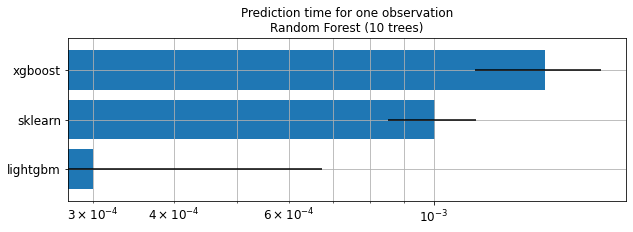

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

**Keep in mind**

* Trained trees are not necessarily the same.
* Performance is not compared.
* Order of magnitude is important here.

### What is batch prediction?

* Instead of running $N$ times 1 prediction
* We run 1 time $N$ predictions

In [26]:
import numpy
memo = []
batch = [1, 2, 5, 7, 8, 10, 100, 200, 500, 1000, 2000, 
         3000, 4000, 5000, 10000, 20000, 50000, 
         100000, 200000, 400000, ]

number = 10
repeat = 10
for i in batch:
    if i <= diabetes_X_test.shape[0]:
        mx = diabetes_X_test[:i]
    else:
        mxs = [diabetes_X_test] * (i // diabetes_X_test.shape[0] + 1)
        mx = numpy.vstack(mxs)
        mx = mx[:i]

    print("batch", "=", i)
    number = 10 if i <= 10000 else 2
    
    memo.append(timeexec("sklearn %d" % i, "rf.predict(mx)", 
                         context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "sklearn"
    
    memo.append(timeexec("xgboost %d" % i, "xg.predict(mx)", 
                         context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "xgboost"
    
    memo.append(timeexec("lightgbm %d" % i, "lg.predict(mx)", 
                         context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "lightgbm"

batch = 1
Average: 1.70 ms deviation 848.36 µs (with 10 runs) in [796.63 µs, 3.97 ms]
Average: 1.71 ms deviation 388.45 µs (with 10 runs) in [1.20 ms, 2.68 ms]
Average: 303.74 µs deviation 167.09 µs (with 10 runs) in [200.86 µs, 776.57 µs]
batch = 2
Average: 1.57 ms deviation 424.13 µs (with 10 runs) in [774.32 µs, 2.36 ms]
Average: 1.65 ms deviation 281.76 µs (with 10 runs) in [1.27 ms, 2.03 ms]
Average: 270.00 µs deviation 128.19 µs (with 10 runs) in [186.19 µs, 626.32 µs]
batch = 5
Average: 1.64 ms deviation 619.84 µs (with 10 runs) in [817.08 µs, 3.11 ms]
Average: 1.70 ms deviation 303.86 µs (with 10 runs) in [1.27 ms, 2.21 ms]
Average: 313.86 µs deviation 124.75 µs (with 10 runs) in [221.83 µs, 612.78 µs]
batch = 7
Average: 1.72 ms deviation 323.33 µs (with 10 runs) in [1.16 ms, 2.18 ms]
Average: 2.07 ms deviation 768.01 µs (with 10 runs) in [1.32 ms, 3.83 ms]
Average: 509.66 µs deviation 317.81 µs (with 10 runs) in [188.69 µs, 1.10 ms]
batch = 8
Average: 2.18 ms deviation 403.45 

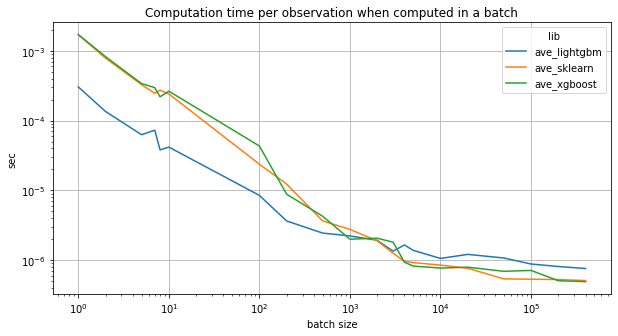

In [27]:
dfb = pandas.DataFrame(memo)[["average", "lib", "batch"]]
piv = dfb.pivot("batch", "lib", "average")
for c in piv.columns:
    piv["ave_" + c] = piv[c] / piv.index
libs = list(c for c in piv.columns if "ave_" in c)
ax = piv.plot(y=libs, logy=True, logx=True, figsize=(10, 5))
ax.set_title("Computation time per observation when computed in a batch")
ax.set_ylabel("sec")
ax.set_xlabel("batch size")
ax.grid(True);

## ONNX

### ONNX = language to describe models

* Standard format to describe machine learning
* Easier to exchange, export

### ONNX = machine learning oriented

* [operators ML](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md)
* [operators](https://github.com/onnx/onnx/blob/master/docs/Operators.md)

Can represent any mathematical function handling numerical and text features.

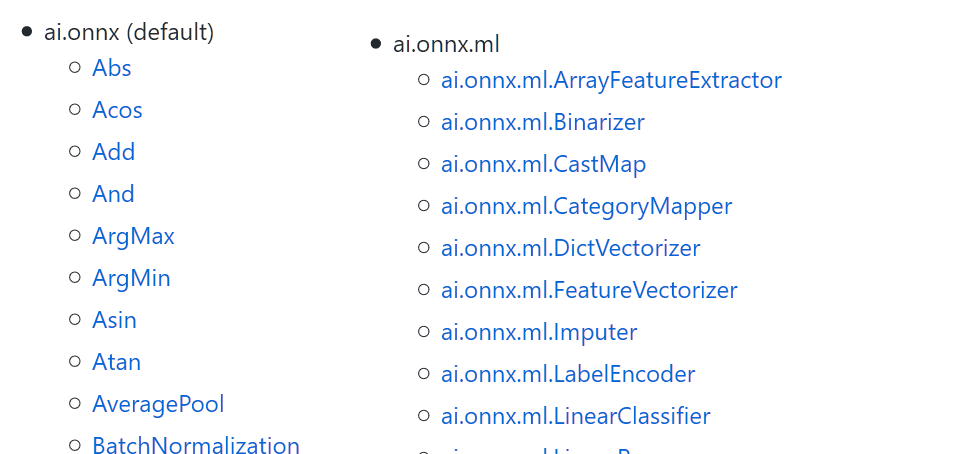

In [28]:
NbImage("onnxop.png", width=600)

### ONNX = efficient serialization

* Based on [google.protobuf](https://developers.google.com/protocol-buffers/)


### actively supported

* Microsoft
* Facebook
* first created to deploy deep learning models
* extended to other models

### Train somewhere, predict somewhere else

**Cannot optimize the code for both training and predicting.**

| Training         | Predicting         |
|------------------|--------------------|
| Batch prediction | One-off prediction |
| Huge memory      | Small memory       |
| Huge data        | Small data         |
| .                | High latency       |

### Libraries for predictions

* Optimized for predictions
* Optimized for a device

### ONNX Runtime

[ONNX Runtime for inferencing machine learning models now in preview](https://azure.microsoft.com/en-us/blog/onnx-runtime-for-inferencing-machine-learning-models-now-in-preview/)

Dedicated runtime for:

* CPU
* GPU
* ...

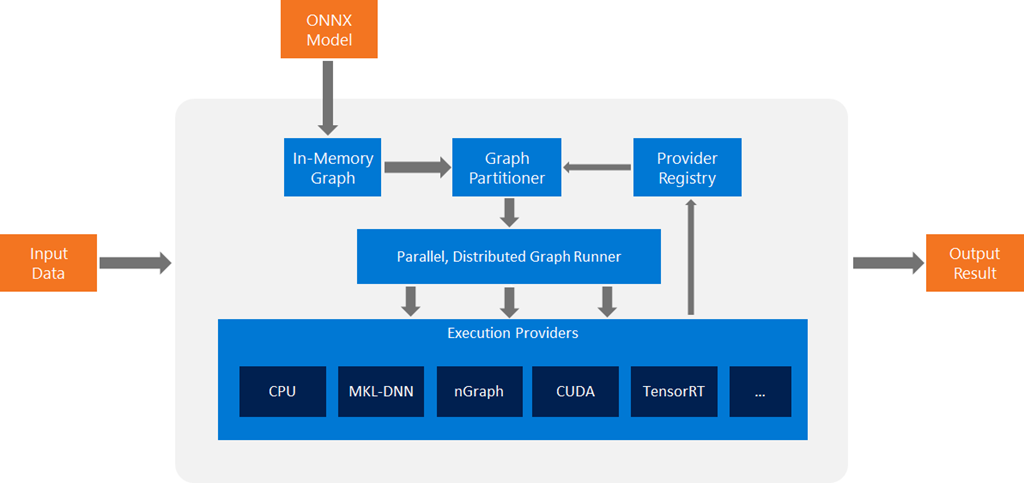

In [29]:
NbImage("onnxrt.png", width=800)

## ONNX demo on random forest

In [31]:
rf

RandomForestRegressor(n_estimators=10)

### Conversion to ONNX

onnxmltools

In [32]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
model_onnx = convert_sklearn(rf, "rf_diabetes", 
                             [('input', FloatTensorType([1, 10]))])

In [33]:
print(str(model_onnx)[:450] + "\n...")

ir_version: 6
producer_name: "skl2onnx"
producer_version: "1.7.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "input"
    output: "variable"
    name: "TreeEnsembleRegressor"
    op_type: "TreeEnsembleRegressor"
    attribute {
      name: "n_targets"
      i: 1
      type: INT
    }
    attribute {
      name: "nodes_falsenodeids"
      ints: 282
      ints: 215
      ints: 212
      ints: 211
      ints: 104
  
...


### Save the model

In [34]:
def save_model(model, filename):
    with open(filename, "wb") as f:
        f.write(model.SerializeToString())

save_model(model_onnx, 'rf_sklearn.onnx')

### Computes predictions

In [35]:
import onnxruntime

sess = onnxruntime.InferenceSession("rf_sklearn.onnx")

for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='input', type='tensor(float)', shape=[1, 10])
Output: NodeArg(name='variable', type='tensor(float)', shape=[1, 1])


In [36]:
import numpy

def predict_onnxrt(x):
    return sess.run(["variable"], {'input': x})

print("Prediction:", predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32)))

Prediction: [array([[223.9]], dtype=float32)]


In [37]:
measures_rf += [timeexec("onnx", "predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32))", 
                         context=globals())]

Average: 24.95 µs deviation 13.21 µs (with 50 runs) in [14.63 µs, 53.23 µs]


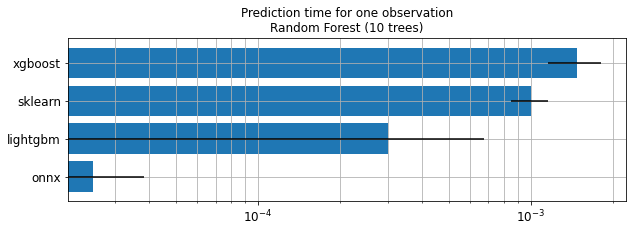

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

## Deep learning

* transfer learning with keras
* orther convert pytorch, caffee...

In [39]:
measures_dl = []

In [40]:
from keras.applications.mobilenet_v2 import MobileNetV2
model = MobileNetV2(input_shape=None, alpha=1.0, include_top=True,
                    weights='imagenet', input_tensor=None,
                    pooling=None, classes=1000)
model

In [41]:
from pyensae.datasource import download_data
import os
if not os.path.exists("simages/noclass"):
    os.makedirs("simages/noclass")
images = download_data("dog-cat-pixabay.zip", 
                       whereTo="simages/noclass")

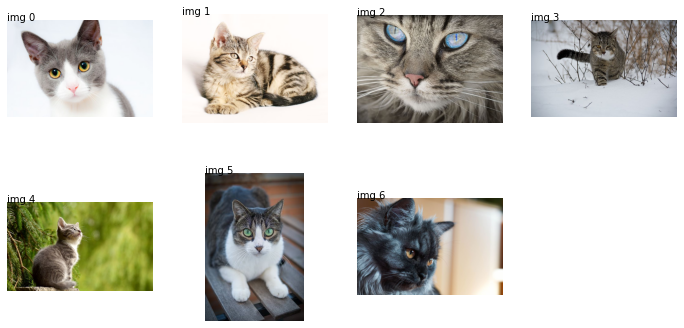

In [42]:
from mlinsights.plotting import plot_gallery_images
plot_gallery_images(images[:7]);

In [43]:
from keras.preprocessing.image import ImageDataGenerator
import numpy
params = dict(rescale=1./255)
augmenting_datagen = ImageDataGenerator(**params)
flow = augmenting_datagen.flow_from_directory('simages', batch_size=1, target_size=(224, 224),
                                              classes=['noclass'], shuffle=False)
imgs = [img[0][0] for i, img in zip(range(0,31), flow)]

Found 31 images belonging to 1 classes.


In [44]:
array_images = [im[numpy.newaxis, :, :, :] for im in imgs]
array_images[0].shape

(1, 224, 224, 3)

In [45]:
outputs = [model.predict(im) for im in array_images]
outputs[0].shape

(1, 1000)

In [46]:
outputs[0].ravel()[:10]

array([3.5999462e-04, 1.2039436e-03, 1.2471736e-04, 6.1937251e-05,
       1.1310312e-03, 1.7601081e-04, 1.9819051e-04, 1.4307769e-04,
       5.5190804e-04, 1.7074021e-04], dtype=float32)

Let's measure time.

In [47]:
from jupytalk.benchmark import timeexec
measures_dl += [timeexec("mobilenet.keras", "model.predict(array_images[0])",
                         context=globals(), repeat=3, number=10)]

Average: 85.39 ms deviation 6.55 ms (with 10 runs) in [80.37 ms, 94.65 ms]


In [48]:
from keras2onnx import convert_keras
try:
    konnx = convert_keras(model, "mobilev2", target_opset=12)
except (ValueError, AttributeError) as e:
    # keras updated its version on 
    print(e)

tf executing eager_mode: True
I0609 11:05:50.269349 34312 main.py:44] tf executing eager_mode: True


'tuple' object has no attribute 'layer'


Let's switch to [pytorch](https://pytorch.org/).

In [49]:
import torchvision.models as models

In [50]:
modelt = models.squeezenet1_1(pretrained=True)
modelt.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [51]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.CenterCrop(224),
                            transforms.ToTensor()])
imgs = datasets.ImageFolder("simages", trans)
dataloader = DataLoader(imgs, batch_size=1, shuffle=False, num_workers=1)
img_seq = iter(dataloader)
imgs = list(img[0] for img in img_seq)

In [52]:
all_outputs = [modelt.forward(img).detach().numpy().ravel() for img in imgs[:2]]
all_outputs[0].shape

(1000,)

In [53]:
measures_dl += [timeexec("squeezenet.pytorch", "modelt.forward(imgs[0]).detach().numpy().ravel()",
                         context=globals(), repeat=3, number=10)]

Average: 59.16 ms deviation 2.33 ms (with 10 runs) in [56.30 ms, 62.02 ms]


Let's convert into ONNX.


In [54]:
import torch.onnx
from torch.autograd import Variable
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
dummy_input = Variable(torch.randn(1, 3, 224, 224))

torch.onnx.export(modelt, dummy_input, "squeezenet.torch.onnx", verbose=False, 
                  input_names=input_names, output_names=output_names)

It works.

In [55]:
from onnxruntime import InferenceSession
sess = InferenceSession('squeezenet.torch.onnx')

In [56]:
inputs = [_.name for _ in sess.get_inputs()]
input_name = inputs[0]
input_name

'actual_input_1'

In [57]:
array_images[0].shape

(1, 224, 224, 3)

In [58]:
res = sess.run(None, {input_name: array_images[0].transpose((0, 3, 1, 2))})
res[0].shape

(1, 1000)

In [59]:
measures_dl += [timeexec("squeezenet.pytorch.onnx",
                         "sess.run(None, {input_name: array_images[0].transpose((0, 3, 1, 2))})",
                         context=globals(), repeat=3, number=10)]

Average: 10.21 ms deviation 1.55 ms (with 10 runs) in [8.20 ms, 11.96 ms]


## Model zoo

[Converted Models](https://github.com/onnx/models)

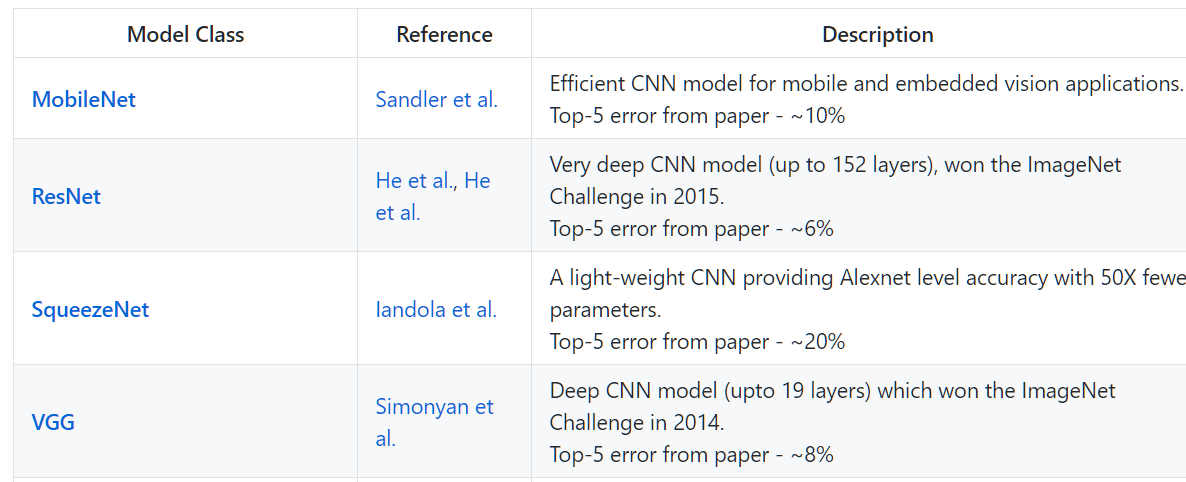

In [60]:
NbImage("zoo.png", width=800)

### MobileNet and SqueezeNet

Download a pre-converted version [MobileNetv2](https://s3.amazonaws.com/onnx-model-zoo/mobilenet/mobilenetv2-1.0/mobilenetv2-1.0.onnx)

In [61]:
download_data("mobilenetv2-1.0.onnx",
              url="https://s3.amazonaws.com/onnx-model-zoo/mobilenet/mobilenetv2-1.0/")

'mobilenetv2-1.0.onnx'

In [62]:
sess = onnxruntime.InferenceSession("mobilenetv2-1.0.onnx")

In [63]:
for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='data', type='tensor(float)', shape=[1, 3, 224, 224])
Output: NodeArg(name='mobilenetv20_output_flatten0_reshape0', type='tensor(float)', shape=[1, 1000])


In [64]:
print(array_images[0].shape)
print(array_images[0].transpose((0, 3, 1, 2)).shape)

(1, 224, 224, 3)
(1, 3, 224, 224)


In [65]:
res = sess.run(None, {'data': array_images[0].transpose((0, 3, 1, 2))})
res[0].shape

(1, 1000)

In [66]:
measures_dl += [timeexec("mobile.zoo.onnx",
                         "sess.run(None, {'data': array_images[0].transpose((0, 3, 1, 2))})",
                         context=globals(), repeat=3, number=10)]

Average: 15.54 ms deviation 2.58 ms (with 10 runs) in [12.61 ms, 18.88 ms]


Download a pre-converted version [SqueezeNet](https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/squeezenet1.1.onnx)

In [67]:
download_data("squeezenet1.1.onnx",
              url="https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/")

'squeezenet1.1.onnx'

In [68]:
sess = onnxruntime.InferenceSession("squeezenet1.1.onnx")
for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='data', type='tensor(float)', shape=[1, 3, 224, 224])
Output: NodeArg(name='squeezenet0_flatten0_reshape0', type='tensor(float)', shape=[1, 1000])


In [69]:
measures_dl += [timeexec("squeezenet.zoo.onnx",
                         "sess.run(None, {'data': array_images[0].transpose((0, 3, 1, 2))})",
                         context=globals(), repeat=3, number=10)]

Average: 13.43 ms deviation 2.10 ms (with 10 runs) in [11.26 ms, 16.28 ms]


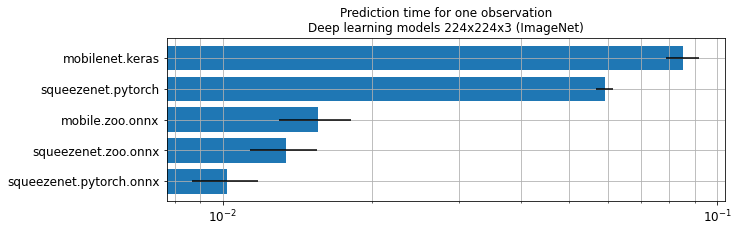

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df = pandas.DataFrame(data=measures_dl)
df = df.set_index("legend").sort_values("average")
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nDeep learning models 224x224x3 (ImageNet)");

### Tiny yolo

Source: [TinyYOLOv2 on onnx](https://mc.ai/tinyyolov2-on-onnx/)

In [71]:
download_data("tiny_yolov2.tar.gz",
              url="https://onnxzoo.blob.core.windows.net/models/opset_8/tiny_yolov2/")

['.\\tiny_yolov2/./Model.onnx',
 '.\\tiny_yolov2/./test_data_set_2/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_2/output_0.pb',
 '.\\tiny_yolov2/./test_data_set_1/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_1/output_0.pb',
 '.\\tiny_yolov2/./test_data_set_0/input_0.pb',
 '.\\tiny_yolov2/./test_data_set_0/output_0.pb']

In [72]:
sess = onnxruntime.InferenceSession("tiny_yolov2/Model.onnx")
for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='image', type='tensor(float)', shape=['None', 3, 416, 416])
Output: NodeArg(name='grid', type='tensor(float)', shape=['None', 125, 13, 13])


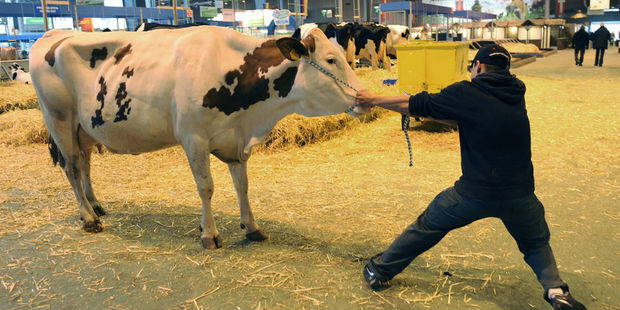

In [73]:
from PIL import Image,ImageDraw
img = Image.open('Au-Salon-de-l-agriculture-la-campagne-recrute.jpg')
img

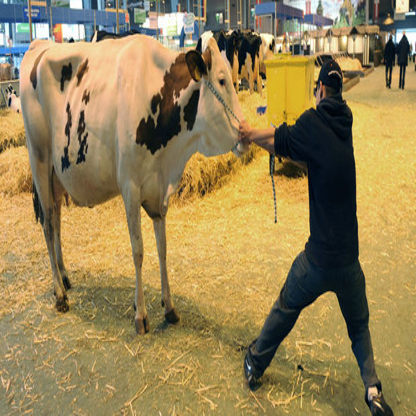

In [74]:
img2 = img.resize((416, 416))
img2

In [75]:
X = numpy.asarray(img2)
X = X.transpose(2,0,1)
X = X.reshape(1,3,416,416)

out = sess.run(None, {'image': X.astype(numpy.float32)})
out = out[0][0]

In [76]:
def display_yolo(img, seuil):
    import numpy as np
    numClasses = 20
    anchors = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]

    def sigmoid(x, derivative=False):
        return x*(1-x) if derivative else 1/(1+np.exp(-x))

    def softmax(x):
        scoreMatExp = np.exp(np.asarray(x))
        return scoreMatExp / scoreMatExp.sum(0)

    clut = [(0,0,0),(255,0,0),(255,0,255),(0,0,255),(0,255,0),(0,255,128),
            (128,255,0),(128,128,0),(0,128,255),(128,0,128),
            (255,0,128),(128,0,255),(255,128,128),(128,255,128),(255,255,0),
            (255,128,128),(128,128,255),(255,128,128),(128,255,128),(128,255,128)]
    label = ["aeroplane","bicycle","bird","boat","bottle",
             "bus","car","cat","chair","cow","diningtable",
             "dog","horse","motorbike","person","pottedplant",
             "sheep","sofa","train","tvmonitor"]

    draw = ImageDraw.Draw(img)
    for cy in range(0,13):
        for cx in range(0,13):
            for b in range(0,5):
                channel = b*(numClasses+5)
                tx = out[channel  ][cy][cx]
                ty = out[channel+1][cy][cx]
                tw = out[channel+2][cy][cx]
                th = out[channel+3][cy][cx]
                tc = out[channel+4][cy][cx]

                x = (float(cx) + sigmoid(tx))*32
                y = (float(cy) + sigmoid(ty))*32

                w = np.exp(tw) * 32 * anchors[2*b  ]
                h = np.exp(th) * 32 * anchors[2*b+1] 

                confidence = sigmoid(tc)

                classes = np.zeros(numClasses)
                for c in range(0,numClasses):
                    classes[c] = out[channel + 5 +c][cy][cx]
                    classes = softmax(classes)
                detectedClass = classes.argmax()

                if seuil < classes[detectedClass]*confidence:
                    color =clut[detectedClass]
                    x = x - w/2
                    y = y - h/2
                    draw.line((x  ,y  ,x+w,y ),fill=color, width=3)
                    draw.line((x  ,y  ,x  ,y+h),fill=color, width=3)
                    draw.line((x+w,y  ,x+w,y+h),fill=color, width=3)
                    draw.line((x  ,y+h,x+w,y+h),fill=color, width=3)
        
    return img

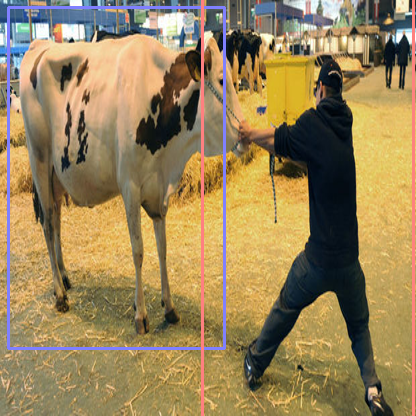

In [77]:
img2 = img.resize((416, 416))
display_yolo(img2, 0.038)

## Conclusion

* ONNX is a working progress, active development
* ONNX is open source
* ONNX does not depend on the machine learning framework
* ONNX provides dedicated runtimes
* ONNX is fast, available in Python...

**Metadata to trace deployed models**

In [78]:
meta = sess.get_modelmeta()
meta.description

"The Tiny YOLO network from the paper 'YOLO9000: Better, Faster, Stronger' (2016), arXiv:1612.08242"

In [79]:
meta.producer_name, meta.version

('OnnxMLTools', 0)